In [146]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from diffusers import UNet2DConditionModel, DDPMScheduler
import torch
from torch.optim import AdamW
from dataset import ADNIDatasetSingleSlice
from torch.utils.data import DataLoader
from utils import sample_16_indices, indices_to_mask, save_tloss_csv, load_or_initialize_training, load_trained_model, plot_batch_slices
import numpy as np
import matplotlib.pyplot as plt

In [147]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [148]:
batch_size = 10

## Experiment 4

In [149]:
num_train_timesteps=256

In [150]:
model = UNet2DConditionModel(
    sample_size=128,
    in_channels=2, #16
    out_channels=1, #8 #initialise to maximum and compute loss only for indexed slices
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    mid_block_type=None,
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
    # not sure about what the lower arguments do
    block_out_channels=(64, 128, 256, 512, 1024), #start with 64? no deeper than 1024
    layers_per_block=2, #default
    # cross_attention_dim=256, # ~concat one-hot encodings of condition and target slices~ NO now instead just one 128 vector with labels 0,1,2
    attention_head_dim=8, #default
    norm_num_groups=32, #default
    use_linear_projection=True #DIFFERENT
)

In [151]:
model.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64

In [152]:
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

In [153]:
load_trained_model(model, 'experiment4/latest_ckpt.pth.tar')

/cim/ehoney/ecse626proj/utils.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Checkpoint loaded from epoch 139.


In [154]:
noised_target_slices = torch.randn(batch_size, 1, 128, 128, device=device)

In [155]:
data_dir = "/cim/ehoney/ecse626proj/preprocessed_data"
train_dataset = ADNIDatasetSingleSlice(data_dir)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8) # CHANGE to NUM_WORKERS=4


In [156]:
one_batch = next(iter(train_dataloader))

In [157]:
_, condition_slices = one_batch

In [158]:
condition_slices = condition_slices.float().to(device)

In [159]:
target_slices = noised_target_slices

# for t in noise_scheduler.timesteps.flip(0):
for t in noise_scheduler.timesteps:
    print(f't is {t}')
    timesteps = torch.tensor([t], device=device, dtype=torch.float32).repeat(batch_size)

    input_tensor = torch.concat((target_slices, condition_slices), dim=1)

    with torch.no_grad():
        predicted_noise = model(input_tensor, timesteps, None).sample

    target_slices = noise_scheduler.step(predicted_noise, t, target_slices).prev_sample

t is 255
t is 254
t is 253
t is 252
t is 251
t is 250
t is 249
t is 248
t is 247
t is 246
t is 245
t is 244
t is 243
t is 242
t is 241
t is 240
t is 239
t is 238
t is 237
t is 236
t is 235
t is 234
t is 233
t is 232
t is 231
t is 230
t is 229
t is 228
t is 227
t is 226
t is 225
t is 224
t is 223
t is 222
t is 221
t is 220
t is 219
t is 218
t is 217
t is 216
t is 215
t is 214
t is 213
t is 212
t is 211
t is 210
t is 209
t is 208
t is 207
t is 206
t is 205
t is 204
t is 203
t is 202
t is 201
t is 200
t is 199
t is 198
t is 197
t is 196
t is 195
t is 194
t is 193
t is 192
t is 191
t is 190
t is 189
t is 188
t is 187
t is 186
t is 185
t is 184
t is 183
t is 182
t is 181
t is 180
t is 179
t is 178
t is 177
t is 176
t is 175
t is 174
t is 173
t is 172
t is 171
t is 170
t is 169
t is 168
t is 167
t is 166
t is 165
t is 164
t is 163
t is 162
t is 161
t is 160
t is 159
t is 158
t is 157
t is 156
t is 155
t is 154
t is 153
t is 152
t is 151
t is 150
t is 149
t is 148
t is 147
t is 146
t is 145
t

In [160]:
predicted_noise.shape

torch.Size([10, 1, 128, 128])

/cim/ehoney/ecse626proj/utils.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


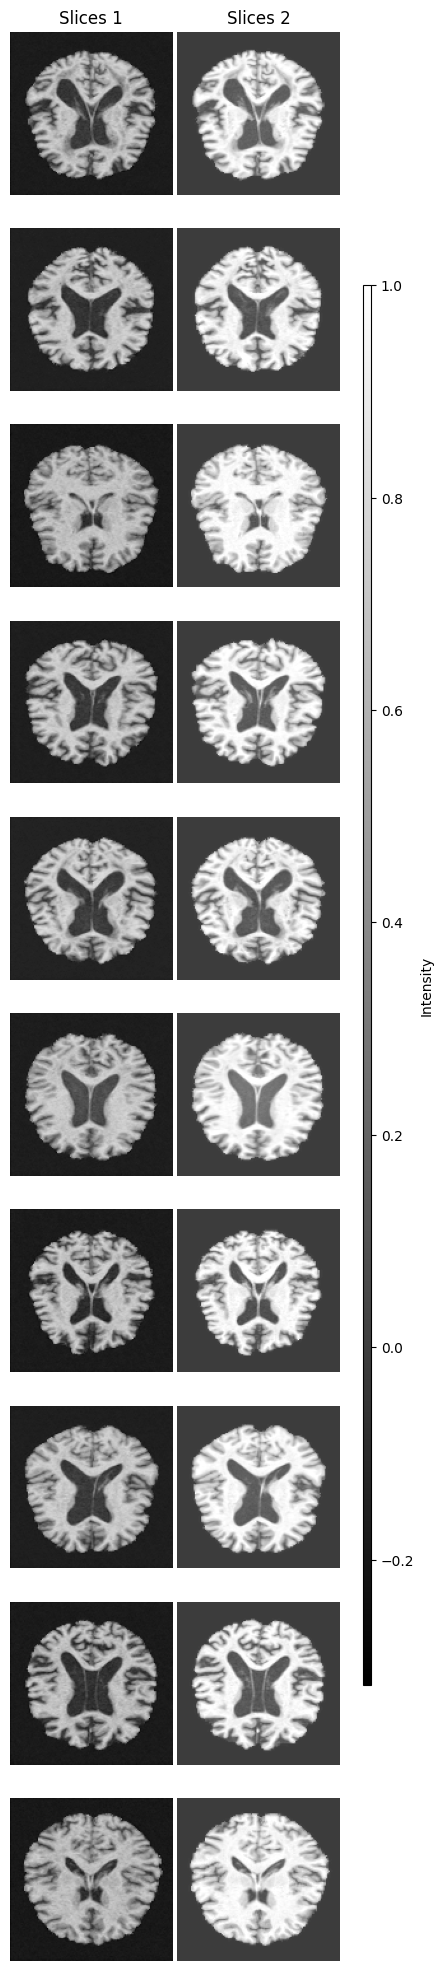

In [161]:
plot_batch_slices(torch.concat((target_slices, condition_slices), dim=1), batch_size=batch_size, slices=2)

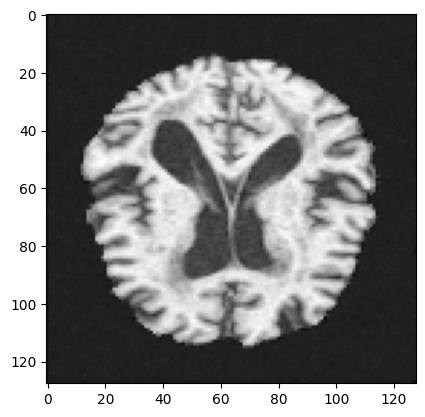

In [162]:
plt.imshow(target_slices[0].squeeze(0).cpu(), cmap='gray')

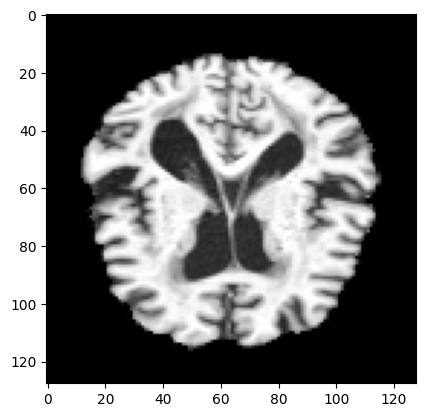

In [163]:
plt.imshow(condition_slices[0].squeeze(0).cpu(), cmap='gray')

### Rough work

In [164]:
slices_at_once=8

In [165]:
first_target_slice = np.random.choice(np.arange(0, 128, slices_at_once))
target_slices = np.arange(first_target_slice, first_target_slice+slices_at_once)
if first_target_slice > 0:
    condition_slices = np.arange(first_target_slice-slices_at_once, first_target_slice)
else:
    condition_slices = np.zeros(slices_at_once)

print(target_slices)
print(condition_slices)

[48 49 50 51 52 53 54 55]
[40 41 42 43 44 45 46 47]


In [166]:
np.zeros((8, 128, 128)).shape

(8, 128, 128)